In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import seaborn as sns
from survAux import *
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import confusion_matrix
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored
import pickle

from lifelines import AalenJohansenFitter
from lifelines.plotting import add_at_risk_counts

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

# Example making Aalen Johansen curve

In [2]:
vte = pd.read_csv('../data/discovery.csv')
vte2 = pd.read_csv('../data/validation.csv')
resbio_msk = pd.read_csv('../data/generalizability_msk.csv')
sydney = pd.read_csv('../data/generalizability_sydney.csv')

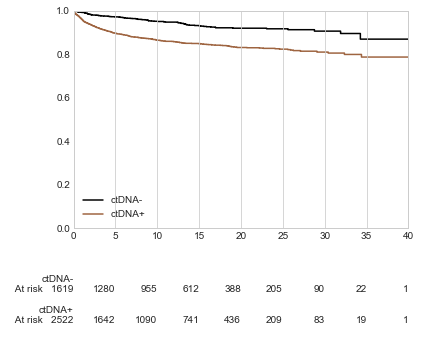

In [3]:
def plotAJF(df,label,ax,**kwargs):
    stopcol='stop'
    startcol='start'
    if 'stop' in kwargs:
        stopcol=kwargs['stop']
    if 'start' in kwargs:
        startcol=kwargs['start']
        
    if not startcol in df.columns:
        df[startcol]=0
        
    df.loc[df[stopcol]<=df[startcol],stopcol] = df[df[stopcol]<=df[startcol]][startcol]+1
    
    aj1 = AalenJohansenFitter()
    aj1.fit(durations=df[stopcol]/daysinmo, 
                     event_observed=df['CAT_DEATH_ENDPT'], 
                     event_of_interest=1,label=label, entry=df[startcol]/daysinmo)
    ax.step(aj1.cumulative_density_.index,1-aj1.cumulative_density_['CIF_1'],label=label)
    
    return aj1

fig, ax=plt.subplots()
ax.set_prop_cycle(color=[plt.cm.copper(i) for i in np.linspace(0, 1, 3)])
aj1 = plotAJF(vte[~vte['+ctDNA']],'ctDNA-',ax)
aj2 = plotAJF(vte[vte['+ctDNA']],'ctDNA+',ax)
ax.grid(visible=False)
ax.set_ylim(0,1)
ax.set_xlim(0,40)
add_at_risk_counts(aj1, aj2, ax=ax, rows_to_show=['At risk'])
ax.legend()

fig.savefig('ctDNA_CAT_discovery.pdf', format='pdf')

In [4]:
# c index
print(concordance_index_censored(vte["CAT_DEATH_ENDPT"]==1, vte['stop'], vte['KHORANA SCORE']))
print(concordance_index_censored(resbio_msk["CAT_DEATH_ENDPT"]==1, resbio_msk['stop'], resbio_msk['KHORANA SCORE']))
print(concordance_index_censored(vte["CAT_DEATH_ENDPT"]==1, vte['stop'], vte['RAM_SCORE']))
print(concordance_index_censored(resbio_msk["CAT_DEATH_ENDPT"]==1, resbio_msk['stop'], resbio_msk['RAM_SCORE']))

(0.5897733532840934, 592481, 344455, 444465, 3536)
(0.6354480827229643, 8513, 3483, 6572, 51)
(0.6200831619493543, 734507, 402741, 244153, 3536)
(0.6557787591555364, 9760, 3975, 4833, 51)


# canonical correlation analysis

<BarContainer object of 2 artists>

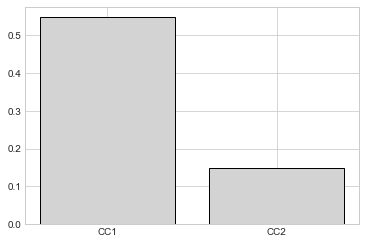

In [12]:
# based on example code: https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

# binarize based on events at 6 months 
# (NOTE this loses information for patients censored < 6mo introducing a small bias)
# see dynamic ROC analyses for a more rigorous assessment

vte_6mo = vte[(vte['CAT_DEATH_ENDPT']>0) & (vte['stop']<180) |\
              (vte['CAT_DEATH_ENDPT']==0) & (vte['stop']>=180)]
vte_6mo['VTE'] = vte_6mo['CAT_DEATH_ENDPT']==1
vte_6mo['died'] = vte_6mo['CAT_DEATH_ENDPT']==2

X1 = vte_6mo[['log10(max VAF)', 'log10(cfDNA concentration)',
       #'DMETS_DX_ADRENAL', 'DMETS_DX_BONE',
       #'DMETS_DX_BRAIN', 'DMETS_DX_LIVER', 'DMETS_DX_LUNG', 'DMETS_DX_LYMPH',
       #'DMETS_DX_PLEURA', 'DMETS_DX_OTHER', 'BMI',
       #'Platelets', 'HGB', 'WBC', #'VTEHX',
       #'TARGETED_HORMONAL', 'PARALYSIS', 'RECENT_IP',
       'chemotherapy', 'STAGE_IV_DX', 'Non-Small Cell Lung Cancer', 'Breast Cancer',
       'Pancreatic Cancer', 'Melanoma', 'Prostate Cancer', 'Bladder Cancer',
       'Esophagogastric Cancer', 'Hepatobiliary Cancer', 'Colorectal Cancer',
       #'lt_start', 'TP53', 'KRAS', 'EGFR', 'PIK3CA', 'CDKN2A', 'ARID1A',
       #'ATM', 'RB1', 'APC', 'NF1', 'KEAP1', 'BRCA2', 'TERT', 'SMAD4', 'STK11',
       #'SF3B1', 'KDM6A', 'AR', 'PTEN', 'ERBB2', 'ESR1', 'BRAF', 'BRCA1',
       #'CDH1', 'GATA3', 'TSC2', 'PTCH1', 'CTNNB1', 'FGFR2', 'FBXW7', 'FGFR3',
       #'DNMT3A', 'KIT', 'TSC1', 'ALK', 'FOXA1', 'SMARCA4', 'MET', 'NTRK3','MSH6',
       'AGE']].fillna(0) # variable (x) columns
X2 = vte_6mo[['VTE','died']] # event (y) columns

scaler = StandardScaler() 
X1_sc = scaler.fit_transform(X1) #scale data
X2_sc = scaler.fit_transform(X2) 
n_comp=2 #choose number of canonical variates pairs 
cca = CCA(scale=False, n_components=n_comp) #define CCA
cca.fit(X1_sc, X2_sc) #fit our scaled data
X1_c, X2_c = cca.transform(X1_sc, X2_sc) #transform our datasests to obtain canonical variates

comp_corr = [np.corrcoef(X1_c[:, i], X2_c[:, i])[1][0] for i in range(n_comp)]
plt.bar(['CC1', 'CC2'], comp_corr, color='lightgrey', width = 0.8, edgecolor='k')

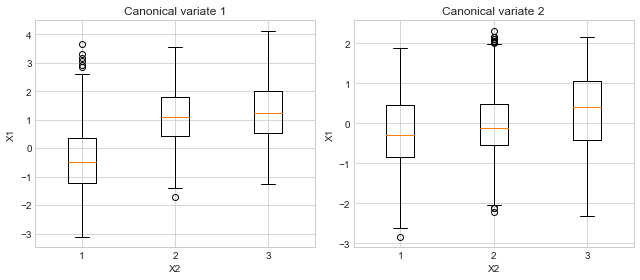

In [13]:
# visualize correlations between CC1 and CC2 for 

def myBoxplot(x,y,ax):
    data_to_plot = {category: [] for category in np.unique(x)}
    for category, value in zip(x, y):
        data_to_plot[category].append(value)

    # Convert to a list of lists for plotting
    data_to_plot = [values for values in data_to_plot.values()]

    # Create the boxplot
    ax.boxplot(data_to_plot)

    ax.set_xlabel('X2')
    ax.set_ylabel('X1')

fig,ax=plt.subplots(ncols=2,figsize=(9,4))
for i in range(n_comp):
    myBoxplot(X2_c[:, i], X1_c[:, i], ax[i])
    ax[i].set_title('Canonical variate '+str(i+1))
fig.tight_layout()

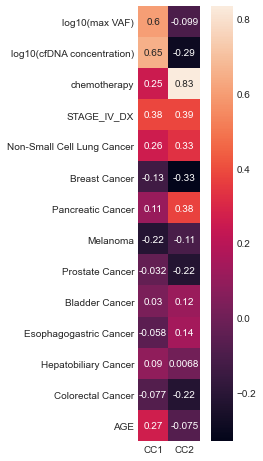

In [19]:
x_loadings = pd.DataFrame(data=cca.x_loadings_,columns = ['CC1','CC2'],index=X1.columns)
fig,ax=plt.subplots(figsize=(4,8))
sns.heatmap(x_loadings,annot=True,square=True,ax=ax)

x_loadings.T.to_csv('CCA_x_loadings.csv')

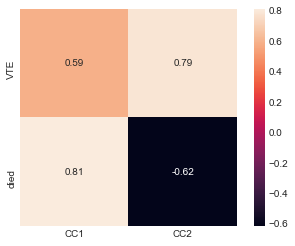

In [16]:
y_loadings = pd.DataFrame(data=cca.y_loadings_,columns = ['CC1','CC2'],index=X2.columns)
sns.heatmap(y_loadings,annot=True,square=True)

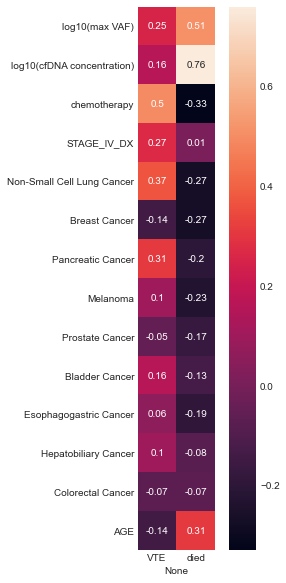

In [17]:
coef_df = pd.DataFrame(np.round(cca.coef_, 2), columns = [X2.columns])
coef_df.index = X1.columns
fig,ax=plt.subplots(figsize=(5,10))
sns.heatmap(coef_df,annot=True,square=True,ax=ax)

# plots from R

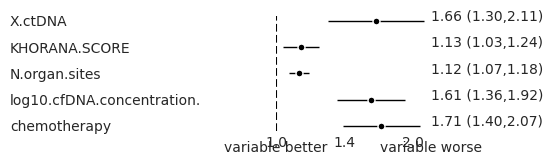

In [4]:
# NOTE meant to be run after Competing Risks R notebook
df = pd.read_csv('multivariate_HR_example.csv',index_col=0)
HRs = pd.Series(list(zip(df['exp(coef)'], 
                         df['2.5%'], 
                         df['97.5%'])),
               index = df.index)
myForest(HRs,'variable worse','variable better','multivariate_HR_example.pdf',(2,1.5))

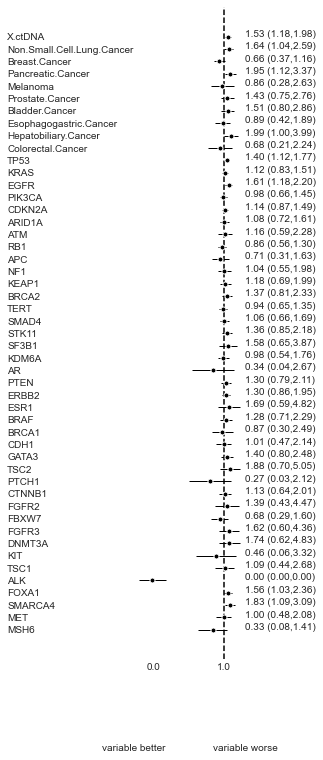

In [6]:
# NOTE meant to be run after Competing Risks R notebook
df = pd.read_csv('multivariate_HR_impact.csv',index_col=0)
HRs = pd.Series(list(zip(df['exp(coef)'], 
                         df['2.5%'], 
                         df['97.5%'])),
               index = df.index)
myForest(HRs,'variable worse','variable better','multivariate_HR_impact.pdf',(2,12))

In [46]:
# Youden index analysis. NOTE also meant to be run after Competing Risks R notebook

# variables of interest (corresponding to file names)
vois = ['log10.max.VAF.',
        'log10.cfDNA.concentration.',
        'KHORANA.SCORE',
        'RAM_SCORE'
       ]

columns = ['TPR (sensitivity)','FNR','FPR','TNR (specificity)',
           "Youden's J",'PPV','NPV','AUC']
summary = pd.DataFrame(columns = columns)

for v in vois:
    roc = pd.read_csv('discovery_ '+v+' _dROC.csv')
    idx = np.argmax(roc.TP - roc.FP)
    tp = roc.iloc[idx].TP #TPR or sensitivity
    fn = 1-tp
    fp = roc.iloc[idx].FP
    tn = 1-fp #TNR or specificity
    J = tp+tn-1
    PPV = tp/(tp+fp)
    NPV = tn/(tn+fn)
    auc = roc.iloc[idx].AUC
    summary.loc[v,columns] = [tp,fn,fp,tn,J,PPV,NPV,auc]

display(summary)
summary.to_csv('YoudenAnalysis_Discovery.csv')

,TPR (sensitivity),FNR,FPR,TNR (specificity),Youden's J,PPV,NPV,AUC
log10.max.VAF.,0.829385,0.170615,0.563251,0.436749,0.266134,0.59555,0.719089,0.660773
log10.cfDNA.concentration.,0.388859,0.611141,0.351695,0.648305,0.0371634,0.525092,0.514754,0.52869
KHORANA.SCORE,0.833947,0.166053,0.648043,0.351957,0.185904,0.562721,0.67944,0.57823
RAM_SCORE,0.771688,0.228312,0.593232,0.406768,0.178455,0.565372,0.640498,0.610484


,TPR (sensitivity),FNR,FPR,TNR (specificity),Youden's J,PPV,NPV,AUC
KHORANA.SCORE,0.833947,0.166053,0.648043,0.351957,0.185904,0.562721,0.67944,0.57823
LB.,0.81977,0.18023,0.439435,0.560565,0.380334,0.651022,0.756707,0.757999
All,0.804103,0.195897,0.400811,0.599189,0.403292,0.667353,0.753615,0.765137


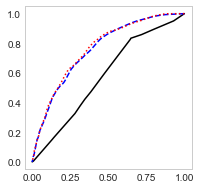

In [62]:
# ROCs

fig,ax = plt.subplots(figsize=(3,3))

# variables of interest (corresponding to file names)
vois = ['KHORANA.SCORE',
        'LB.',
        'All'
       ]

columns = ['TPR (sensitivity)','FNR','FPR','TNR (specificity)',
           "Youden's J",'PPV','NPV','AUC']
summary = pd.DataFrame(columns = columns)

stypes = ['k','b--','r:']

for i, v in enumerate(vois):
    roc = pd.read_csv('discovery_ '+v+' _dROC.csv')
    ax.plot(roc.FP,roc.TP,stypes[i],label=v)
    
    idx = np.argmax(roc.TP - roc.FP)
    tp = roc.iloc[idx].TP #TPR or sensitivity
    fn = 1-tp
    fp = roc.iloc[idx].FP
    tn = 1-fp #TNR or specificity
    J = tp+tn-1
    PPV = tp/(tp+fp)
    NPV = tn/(tn+fn)
    auc = roc.iloc[idx].AUC
    summary.loc[v,columns] = [tp,fn,fp,tn,J,PPV,NPV,auc]

display(summary)
#ax.legend()
ax.grid(False)
fig.savefig('discovery_ROC.pdf',format='pdf')

,TPR (sensitivity),FNR,FPR,TNR (specificity),Youden's J,PPV,NPV,AUC
KHORANA.SCORE,0.904141,0.0958594,0.718688,0.281312,0.185452,0.557139,0.745846,0.617579
LB.,0.753968,0.246032,0.355936,0.644064,0.398032,0.679309,0.723589,0.741636
All,0.73803,0.26197,0.347228,0.652772,0.390802,0.68005,0.713613,0.743111


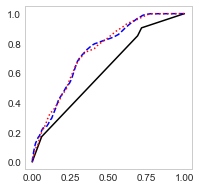

In [64]:
# ROCs

fig,ax = plt.subplots(figsize=(3,3))

# variables of interest (corresponding to file names)
vois = ['KHORANA.SCORE',
        'LB.',
        'All'
       ]

columns = ['TPR (sensitivity)','FNR','FPR','TNR (specificity)',
           "Youden's J",'PPV','NPV','AUC']
summary = pd.DataFrame(columns = columns)

stypes = ['k','b--','r:']

for i, v in enumerate(vois):
    roc = pd.read_csv('validation_ '+v+' _dROC.csv')
    ax.plot(roc.FP,roc.TP,stypes[i],label=v)
    
    idx = np.argmax(roc.TP - roc.FP)
    tp = roc.iloc[idx].TP #TPR or sensitivity
    fn = 1-tp
    fp = roc.iloc[idx].FP
    tn = 1-fp #TNR or specificity
    J = tp+tn-1
    PPV = tp/(tp+fp)
    NPV = tn/(tn+fn)
    auc = roc.iloc[idx].AUC
    summary.loc[v,columns] = [tp,fn,fp,tn,J,PPV,NPV,auc]

display(summary)
#ax.legend()
ax.grid(False)
fig.savefig('validation_ROC.pdf',format='pdf')

,TPR (sensitivity),FNR,FPR,TNR (specificity),Youden's J,PPV,NPV,AUC
KHORANA.SCORE,0.168245,0.831755,0.0811635,0.918837,0.0870814,0.674576,0.524872,0.496179
LB.,0.937968,0.0620325,0.646959,0.353041,0.291009,0.591805,0.850551,0.663702
All,0.733537,0.266463,0.460294,0.539706,0.273243,0.61444,0.66947,0.662979


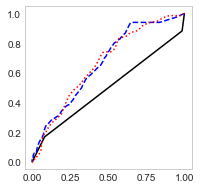

In [63]:
# ROCs

fig,ax = plt.subplots(figsize=(3,3))

# variables of interest (corresponding to file names)
vois = ['KHORANA.SCORE',
        'LB.',
        'All'
       ]

columns = ['TPR (sensitivity)','FNR','FPR','TNR (specificity)',
           "Youden's J",'PPV','NPV','AUC']
summary = pd.DataFrame(columns = columns)

stypes = ['k','b--','r:']

for i, v in enumerate(vois):
    roc = pd.read_csv('generalizability_ '+v+' _dROC.csv')
    ax.plot(roc.FP,roc.TP,stypes[i],label=v)
    
    idx = np.argmax(roc.TP - roc.FP)
    tp = roc.iloc[idx].TP #TPR or sensitivity
    fn = 1-tp
    fp = roc.iloc[idx].FP
    tn = 1-fp #TNR or specificity
    J = tp+tn-1
    PPV = tp/(tp+fp)
    NPV = tn/(tn+fn)
    auc = roc.iloc[idx].AUC
    summary.loc[v,columns] = [tp,fn,fp,tn,J,PPV,NPV,auc]

display(summary)
#ax.legend()
ax.grid(False)
fig.savefig('generalizability_ROC.pdf',format='pdf')

# use RSFs to make predictions

In [15]:
# NOTE: meant to be run AFTER run_rsf_vte.py
# *** models are too large to store on github so must be trained locally ***

with open('models/LB+.pkl', 'rb') as f:
    rf = pickle.load(f)

vte2 = pd.read_csv('../data/validation.csv') # <--substitute with your file (must contain lbplus_cols)

# add gene columns
xs_common_genes = pd.read_csv('common_gene_list.txt')
def queryOncogenicMutations(s, g):
    tok = s.split(';')
    if len(tok)>0:
        return sum([g==t.split(' ')[0] for t in tok])>0
    return False
for g in list(xs_common_genes['Gene']):
    vte2[g]=vte2['ONCOGENIC_MUTATIONS'].fillna('').apply(lambda x: queryOncogenicMutations(x, g))
    
common_cancers = ['Non-Small Cell Lung Cancer',
 'Breast Cancer',
 'Pancreatic Cancer',
 'Melanoma',
 'Prostate Cancer',
 'Bladder Cancer',
 'Esophagogastric Cancer',
 'Hepatobiliary Cancer',
 'Colorectal Cancer']

lbplus_cols = list(xs_common_genes['Gene'])+['+ctDNA','log10(max VAF)','log10(cfDNA concentration)']+common_cancers+['chemotherapy']

preds = rf.predict(vte2[lbplus_cols])

# comparing RSF with vs without competing risks

In [3]:
riskscores_deathcensor = pd.read_csv('vte_riskscores_validation.csv')
riskscores_cmprsk = pd.read_csv('vte_riskscores_validation_cmprsk.csv')

Text(0.5, 1.0, 'risk scores in validation cohort')

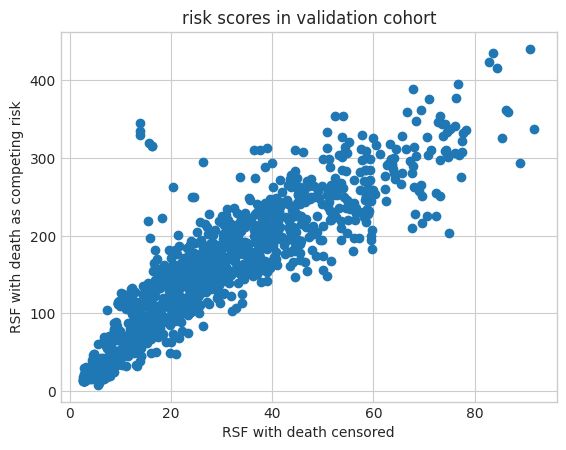

In [5]:
plt.scatter(riskscores_deathcensor['LB+'],
            riskscores_cmprsk['event.1'])
plt.xlabel('RSF with death censored')
plt.ylabel('RSF with death as competing risk')
plt.title('risk scores in validation cohort')

Text(0.5, 1.0, 'risk scores for two endpoints in validation cohort with competing risks RSF')

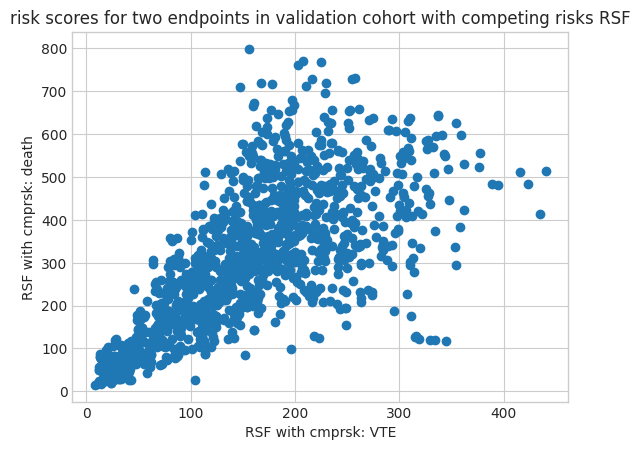

In [7]:
plt.scatter(riskscores_cmprsk['event.1'],
           riskscores_cmprsk['event.2'])
plt.xlabel('RSF with cmprsk: VTE')
plt.ylabel('RSF with cmprsk: death')
plt.title('risk scores for two endpoints in validation cohort with competing risks RSF')